# Librerias

In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
import missingno as msno
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Datos

In [2]:
ruta = 'df_solares.xlsx'
df = pd.read_excel(ruta, engine='openpyxl')

In [3]:
df.drop(columns={'Hora','Region','Provincia','Comuna','Nombre Propietario','Tecnologia'}, inplace=True)

In [4]:
ruta = 'df_eolicos.xlsx'
dfe = pd.read_excel(ruta, engine='openpyxl')
del ruta

In [5]:
dfe.drop(columns={'Hora','Region','Provincia','Comuna','Nombre Propietario','Tecnologia'}, inplace=True)

## Valores perdidos (Interpolación)

In [6]:
df.dtypes

Real                         float64
Nombre                        object
Fecha                 datetime64[ns]
Externo                      float64
Coordinado                   float64
SExperto                     float64
Vertimiento                  float64
Potencia_max_bruta           float64
dtype: object

In [7]:
df.isnull().sum()

Real                      62
Nombre                     0
Fecha                      0
Externo                78542
Coordinado             93182
SExperto              106004
Vertimiento           223622
Potencia_max_bruta         0
dtype: int64

<Axes: >

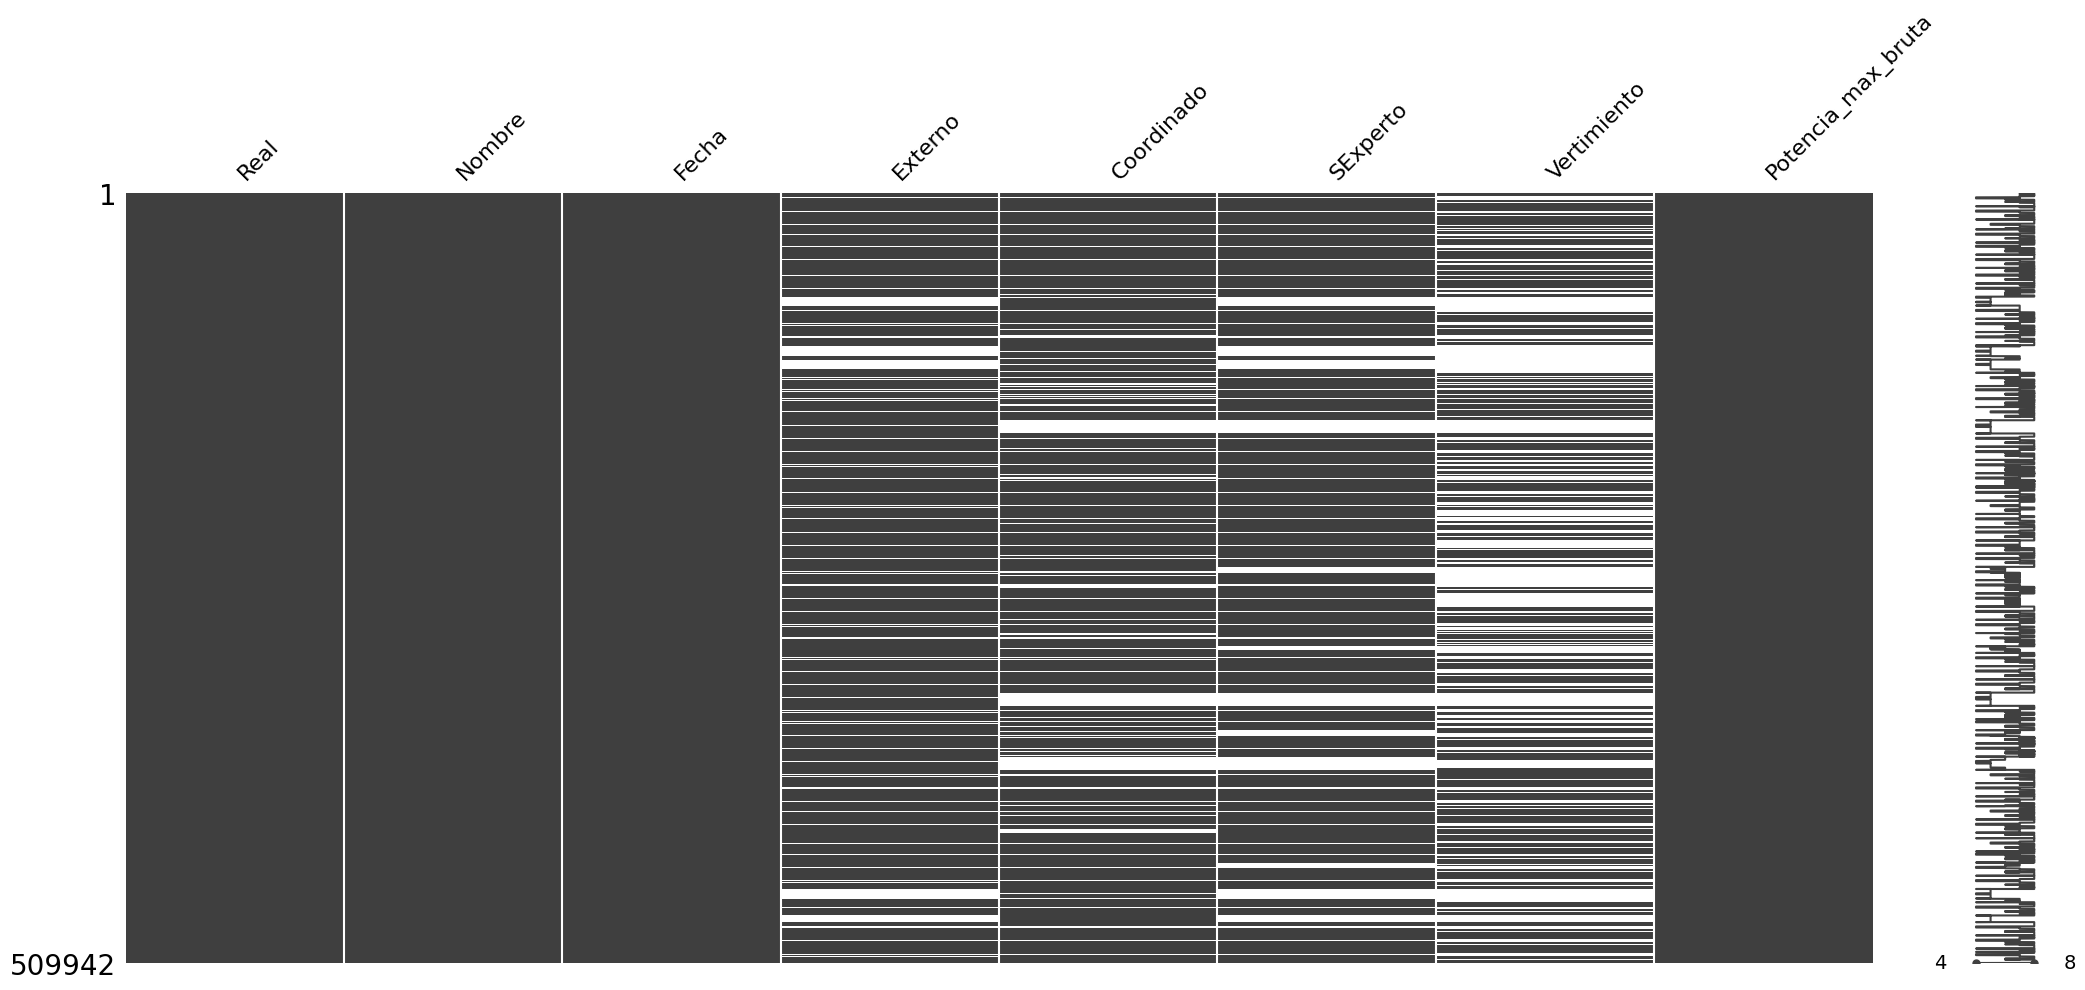

In [6]:
df.sort_values(by='Fecha')
msno.matrix(df)

In [8]:
# Calcular el coeficiente de asimetría
pronosticos = ['Real', 'Externo', 'Coordinado', 'SExperto']
print(pronosticos)
for i in pronosticos:

  skewness = df[i].skew()
  print(f"Coeficiente de Asimetría: {skewness}")

  # Interpretación del resultado
  if skewness > 0:
      print(f"La distribución de {i} tiene un sesgo positivo (hacia la derecha).")
  elif skewness < 0:
      print(f"La distribución de {i} tiene un sesgo negativo (hacia la izquierda).")
  else:
      print(f"La distribución de {i} es aproximadamente simétrica.")
del skewness, pronosticos, i

['Real', 'Externo', 'Coordinado', 'SExperto']
Coeficiente de Asimetría: 2.687846633062125
La distribución de Real tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 2.4600070215871415
La distribución de Externo tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 2.378657226430205
La distribución de Coordinado tiene un sesgo positivo (hacia la derecha).
Coeficiente de Asimetría: 2.26252988146878
La distribución de SExperto tiene un sesgo positivo (hacia la derecha).


In [9]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df.isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))

Vertimiento           43.852438
SExperto              20.787462
Coordinado            18.273059
Externo               15.402144
Real                   0.012158
Nombre                 0.000000
Fecha                  0.000000
Potencia_max_bruta     0.000000
dtype: float64


In [10]:
# Conteo de filas con valores faltantes
filas_con_faltantes = df.isna().any(axis=1).sum()
print(f"Número de filas con al menos un valor faltante: {filas_con_faltantes}")
del filas_con_faltantes

Número de filas con al menos un valor faltante: 257897


In [11]:
df = df.sort_values('Fecha')
df_imputado = df.interpolate()

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\3836364637.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_imputado = df.interpolate()


In [12]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df_imputado .isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))
del porcentaje_faltantes

Real                  0.009805
Nombre                0.000000
Fecha                 0.000000
Externo               0.000000
Coordinado            0.000000
SExperto              0.000000
Vertimiento           0.000000
Potencia_max_bruta    0.000000
dtype: float64


In [13]:
mask = df_imputado.isna().any(axis=1)

# Filtrar el DataFrame para mostrar solo esas filas
df_con_valores_vacios = df_imputado[mask]

print(df_con_valores_vacios['Fecha'].dt.hour.unique())
del df_con_valores_vacios,  mask

[0]


In [14]:
df_imputado = df_imputado.fillna(0)

In [15]:
# Porcentaje de valores faltantes por columna
porcentaje_faltantes = df_imputado.isna().mean() * 100
print(porcentaje_faltantes.sort_values(ascending=False))
del porcentaje_faltantes

Real                  0.0
Nombre                0.0
Fecha                 0.0
Externo               0.0
Coordinado            0.0
SExperto              0.0
Vertimiento           0.0
Potencia_max_bruta    0.0
dtype: float64


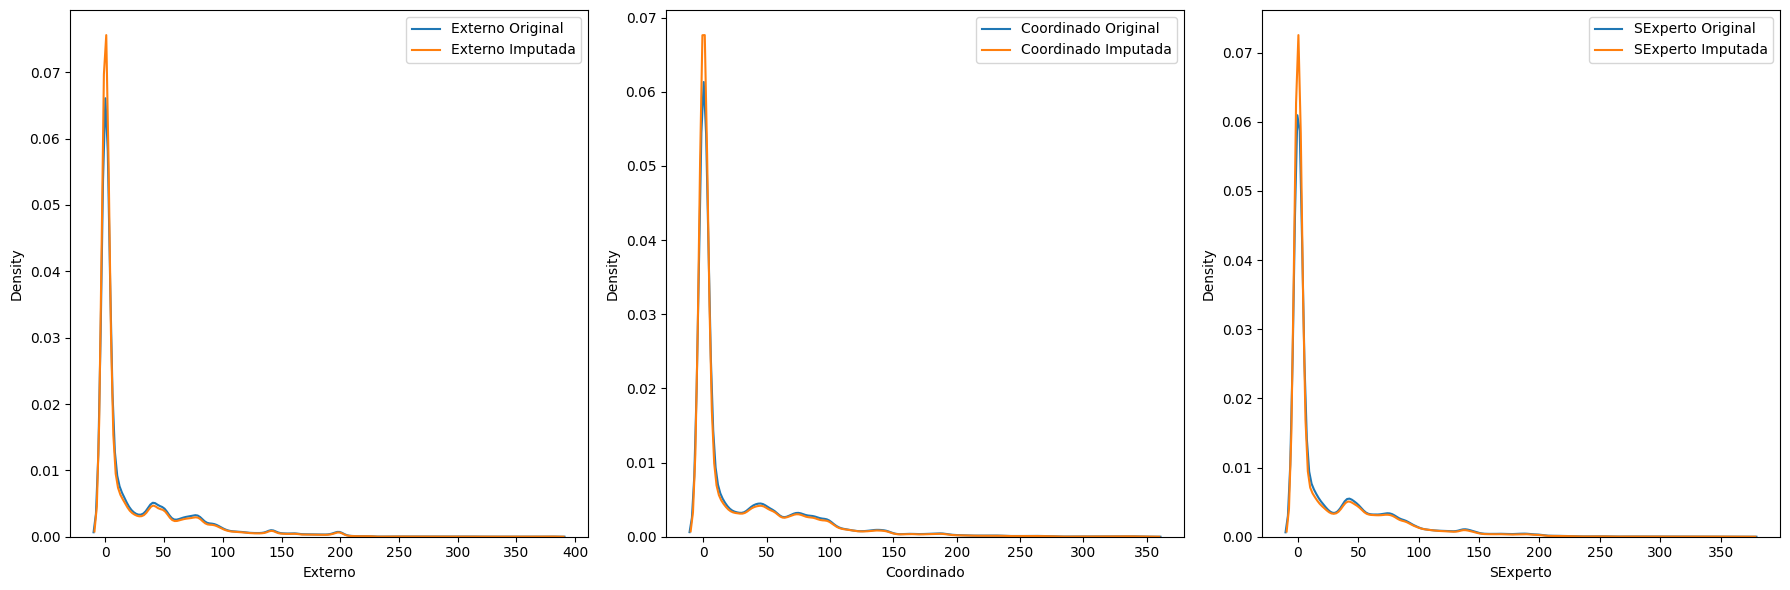

In [16]:
columnas = ['Externo', 'Coordinado', 'SExperto']

plt.figure(figsize=(18, 6))
for i, columna in enumerate(columnas, 1):
    plt.subplot(1, len(columnas), i)
    sn.kdeplot(df[f'{columna}'].dropna(), label=f'{columna} Original')
    sn.kdeplot(df_imputado[f'{columna}'], label=f'{columna} Imputada')
    plt.legend()
plt.tight_layout()
plt.show()
del columnas, i

## Transformación: Generación potencial

In [17]:
df_edit = df_imputado.copy()

In [18]:
# Sumar las columnas 'Real' y 'Vertimiento' para obtener la generación potencial
df_edit['Generacion_Potencial'] = df_edit['Real'].fillna(0) + df_edit['Vertimiento'].fillna(0)
df_edit.drop(columns={'Real','Vertimiento'}, inplace=True)


In [19]:
df_edit

,Nombre,Fecha,Externo,Coordinado,SExperto,Potencia_max_bruta,Generacion_Potencial
0,PFV ALMEYDA,2023-01-01,0.0,0.0,0.0,56.8000,0.0
168019,PFV EL ROMERO,2023-01-01,0.0,0.0,0.0,196.0000,0.0
265135,PFV LALACKAMA II,2023-01-01,0.0,0.0,0.0,16.5000,0.0
176780,PFV FINIS TERRAE,2023-01-01,0.0,0.0,0.0,248.2100,0.0
40853,PFV BOLERO,2023-01-01,0.0,0.0,0.0,138.2000,0.0
...,...,...,...,...,...,...,...
460926,PFV SOL DEL DESIERTO,2024-01-01,0.0,0.0,0.0,230.4800,0.0
230090,PFV LA CRUZ SOLAR,2024-01-01,0.0,0.0,0.0,52.8137,0.0
221329,PFV JAVIERA,2024-01-01,0.0,0.0,0.0,69.0180,0.0
212568,PFV JAMA,2024-01-01,0.0,0.0,0.0,52.6500,0.0


## Limpieza: filtración de horas sin actividad solar

In [20]:
df_edit.set_index('Fecha', inplace=True)
df_edit['Hora'] = df_edit.index.hour
df_edit.reset_index(inplace=True)

In [21]:
df_maxima_generacion = df_edit.groupby(['Nombre', 'Hora'])['Generacion_Potencial'].max().reset_index()
# Luego, necesitas obtener los valores únicos de 'Potencia_max_bruta' por 'Nombre'
potencia_maxima = df_edit.groupby('Nombre')['Potencia_max_bruta'].max().reset_index()

# Finalmente, haces un merge para agregar 'Potencia_max_bruta' a tu df_maxima_generacion
df_maxima_generacion = df_maxima_generacion.merge(potencia_maxima, on='Nombre', how='left')

#dataframe con las horas por central que tienen maxima generación igual 0
#maxGenCero =df_maxima_generacion[df_maxima_generacion['Generacion_Potencial'] == 0 ]
maxGenCero =df_maxima_generacion[df_maxima_generacion['Generacion_Potencial'] <= df_maxima_generacion['Potencia_max_bruta']*0.001 ]
#Eliminamos columna para no obtener una duplicada en el merge
maxGenCero.drop(columns={'Generacion_Potencial'}, inplace=True)
#Hacemos un df con las filas que queremos eliminar
dfEliminar = pd.merge(df_edit, maxGenCero, on=['Nombre', 'Hora'], how='inner')

# Asumiendo que df_eliminar contiene las filas a eliminar basadas en 'Nombre' y 'Hora'
# Creamos un identificador único combinando 'Nombre' y 'Hora' para ambas DataFrames
df_edit['identificador'] = df_edit['Nombre'] + df_edit['Fecha'].astype(str)
dfEliminar['identificador'] = dfEliminar['Nombre'] + dfEliminar['Fecha'].astype(str)

# Filtramos df_solares para excluir las filas cuyos identificadores están en df_eliminar
identificadores_para_eliminar = set(dfEliminar['identificador'])
df_limpio = df_edit[~df_edit['identificador'].isin(identificadores_para_eliminar)]

# Opcional: Puedes eliminar la columna 'identificador' si ya no la necesitas
df_limpio.drop(columns=['identificador', 'Hora'], inplace=True)
del df_maxima_generacion, maxGenCero, identificadores_para_eliminar, dfEliminar, df_edit

# Ahora df_solares_limpio contiene solo las filas que no están en df_eliminar


C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\2075979434.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  maxGenCero.drop(columns={'Generacion_Potencial'}, inplace=True)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\2075979434.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio.drop(columns=['identificador', 'Hora'], inplace=True)


## Variable hora (para dummies)

In [22]:
df_limpio['Hora'] = df_limpio['Fecha'].dt.hour

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\3325857352.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_limpio['Hora'] = df_limpio['Fecha'].dt.hour


In [23]:
df_limpio['Hora'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

## Analisis exploratorio

In [24]:
central = 'PFV FINIS TERRAE'
datos_central = df_limpio[df_limpio['Nombre']== central]

In [25]:
 hor4= datos_central[datos_central['Hora'] == 6]

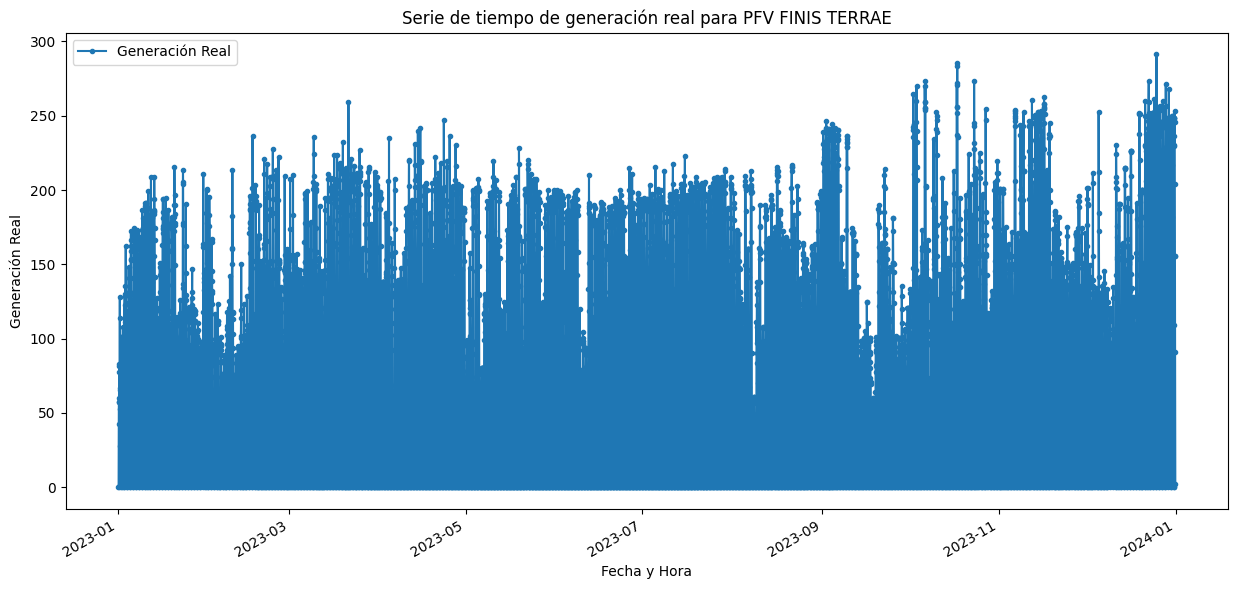

In [27]:
#Filtrar  datos por central
central = 'PFV FINIS TERRAE'
datos_central = df_limpio[df_limpio['Nombre']== central]

# Asegurarse de que los datos estén ordenados por fecha
datos_central = datos_central.sort_values(by='Fecha')

 # Crear un nuevo gráfico
plt.figure(figsize=(15, 7))
    
    # Trazar la serie de tiempo de la generación real
plt.plot(datos_central['Fecha'], datos_central['Generacion_Potencial'], label='Generación Real', marker='o', linestyle='-', markersize=3)

  # Añadir título y leyenda al gráfico
plt.title(f"Serie de tiempo de generación real para {central}")
plt.xlabel('Fecha y Hora')
plt.ylabel('Generación Real')
plt.legend()

# Mejorar el formato de la fecha en el eje x
plt.gcf().autofmt_xdate()

# Mostrar el gráfico
plt.show()




In [28]:
print(len(df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()))
df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()


16


array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

# Regresión

In [223]:
Y = datos_central['Generacion_Potencial']
dummies = pd.get_dummies(datos_central['Hora'], drop_first=True, prefix='h')
dummies = dummies.astype(float)
X = pd.concat([datos_central['Externo'],datos_central['Coordinado'], dummies],axis=1)
X = sm.add_constant(X)

In [224]:
X

,const,Externo,Coordinado,h_7,h_8,h_9,h_10,h_11,h_12,h_13,h_14,h_15,h_16,h_17,h_18,h_19,h_20,h_21
332,1.0,0.2,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
390,1.0,20.3,36.09,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
407,1.0,83.3,135.79,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
472,1.0,105.4,212.18,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
546,1.0,110.1,244.09,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509463,1.0,152.3,241.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
509508,1.0,143.2,196.79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
509630,1.0,68.3,86.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
509658,1.0,2.5,7.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Sliding window

In [225]:
horas_relevantes = df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()
horas_relevantes

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [226]:
# Dividir el DataFrame filtrado en entrenamiento y prueba
num_dias_entrenamiento = 120
filas_por_dia = len(horas_relevantes)
# Calcular el número de días en el DataFrame
dias_totales = len(X) // filas_por_dia
print(dias_totales)
# Multiplica por la cantidad de horas relevantes por día para obtener el punto de corte
punto_corte = num_dias_entrenamiento * len(horas_relevantes)
# Crear un DataFrame vacío para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()
potencia_maxima = datos_central['Potencia_max_bruta'].max()


365


In [227]:

# Agregamos Interacciones a la variabl X
var_ind = ['Externo', 'Coordinado']
for var in var_ind:
    for dummie in dummies.columns:
        nombre_interaccion = f'{var}-{dummie}'
        X[nombre_interaccion] = X[var] * X[dummie]

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las variables de predicción de cada día
variables_prediccion_df = pd.DataFrame()

# Iterar a través de los días, ajustando el modelo y realizando predicciones
for dia in range(dias_totales - num_dias_entrenamiento):
    # Definir el conjunto de entrenamiento para la ventana actual
    inicio = dia * filas_por_dia
    fin = inicio + num_dias_entrenamiento * filas_por_dia
    X_train = X.iloc[inicio:fin]
    Y_train = Y.iloc[inicio:fin]

    # Ajustar el modelo
    modelo = sm.OLS(Y_train, X_train).fit()

    # Extraer y almacenar los parámetros estimados para la fecha actual
    parametros_actuales = modelo.params
    parametros_df = pd.concat([parametros_df, pd.DataFrame(parametros_actuales).T])

    # Realizar predicciones para el siguiente día
    X_test = X.iloc[fin:fin + filas_por_dia]
    predicciones = modelo.predict(X_test)

    # Aplicar el límite inferior y superior a las predicciones
    predicciones = np.maximum(predicciones, 0)  # Límite inferior, asegurando que la predicción no sea menor que 0
    predicciones = np.minimum(predicciones, potencia_maxima)  # Límite superior

    # Almacenar las predicciones
    predicciones_df = pd.concat([predicciones_df, predicciones])

    # Almacenar las variables utilizadas para la predicción del nuevo día
    variables_prediccion_df = pd.concat([variables_prediccion_df, X_test])

# Restablecer los índices de los DataFrames
parametros_df.reset_index(drop=True, inplace=True)
predicciones_df.reset_index(drop=True, inplace=True)
variables_prediccion_df.reset_index(drop=True, inplace=True)

# Ahora 'parametros_df' contiene los parámetros estimados de cada modelo, 'predicciones_df' las predicciones, 
# y 'variables_prediccion_df' las variables utilizadas para cada predicción.
print(parametros_df)
print(predicciones_df)
print(variables_prediccion_df)

# Eliminación de variables pesadas para optimizar la memoria
del X, X_train, X_test


            const       Externo    Coordinado       h_7        h_8  \
0   -1.199243e-11  2.686632e-10  3.077032e-11  0.008874 -29.600913   
1   -4.213205e-12  2.643061e-10 -1.989582e-11  0.008969 -25.153791   
2   -2.922457e-12  2.518050e-10 -3.663493e-11  0.008971 -21.364261   
3   -6.690039e-12  2.163380e-09 -3.426584e-10  0.009202 -18.028700   
4    1.483579e-12 -4.201438e-10  5.433261e-11  0.009190 -15.988227   
..            ...           ...           ...       ...        ...   
240  1.241775e-03  5.940896e-02 -1.024481e-03 -0.049791 -39.188478   
241  1.236764e-03  5.754954e-02 -9.764491e-04 -0.053830 -37.705208   
242  1.231834e-03  5.579847e-02 -9.311772e-04 -0.058574 -37.155736   
243  1.227215e-03  5.414436e-02 -8.883174e-04  0.019465 -39.600531   
244  1.385677e-03  5.144658e-02 -8.323242e-04  0.007620 -35.613374   

            h_9        h_10        h_11        h_12        h_13  ...  \
0   -100.628275  104.696962   91.154339  119.511308  158.952593  ...   
1    -51.552497

#  Prediction Dataset

In [229]:
predicciones_df['pred'] = predicciones_df[0]
predicciones_df['pred'].dtypes
#predicciones_df.loc[predicciones_df['pred'] < 0, 'pred'] = 0
predicciones_df.reset_index(inplace=True, drop='index')

In [231]:
dc245  = pd.DataFrame()
dc245 = datos_central.iloc[num_dias_entrenamiento*filas_por_dia:]
dc245.reset_index(inplace=True)
dc245['pred'] = predicciones_df['pred']
dc245['dia'] = dc245['Fecha'].dt.date
# Usar factorize() para crear los identificadores únicos
dc245['identificador'] = pd.factorize(dc245['dia'])[0]
dc245

C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\4011148655.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc245['pred'] = predicciones_df['pred']
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\4011148655.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dc245['dia'] = dc245['Fecha'].dt.date
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\4011148655.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

,index,Fecha,Nombre,Externo,Coordinado,SExperto,Potencia_max_bruta,Generacion_Potencial,Hora,pred,dia,identificador
0,153025,2023-05-01 06:00:00,PFV FINIS TERRAE,0.0,0.00,0.000,248.21,0.000000,6,0.000000,2023-05-01,0
1,153073,2023-05-01 07:00:00,PFV FINIS TERRAE,0.0,0.00,0.000,248.21,0.010000,7,0.008874,2023-05-01,0
2,153181,2023-05-01 08:00:00,PFV FINIS TERRAE,0.0,0.00,0.000,248.21,37.963667,8,0.000000,2023-05-01,0
3,153219,2023-05-01 09:00:00,PFV FINIS TERRAE,0.0,0.00,0.000,248.21,59.410000,9,0.000000,2023-05-01,0
4,153251,2023-05-01 10:00:00,PFV FINIS TERRAE,0.0,0.00,0.000,248.21,64.653778,10,104.696962,2023-05-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3915,509463,2023-12-31 17:00:00,PFV FINIS TERRAE,152.3,241.25,131.036,248.21,204.208833,17,150.328923,2023-12-31,244
3916,509508,2023-12-31 18:00:00,PFV FINIS TERRAE,143.2,196.79,130.640,248.21,155.650000,18,168.330208,2023-12-31,244
3917,509630,2023-12-31 19:00:00,PFV FINIS TERRAE,68.3,86.38,64.141,248.21,155.590000,19,134.370601,2023-12-31,244
3918,509658,2023-12-31 20:00:00,PFV FINIS TERRAE,2.5,7.34,1.404,248.21,91.160000,20,95.856677,2023-12-31,244


## Outliers

In [232]:
# Calculando el rango intercuartílico (IQR)
Q1 = dc245['pred'].quantile(0.25)
Q3 = dc245['pred'].quantile(0.75)
IQR = Q3 - Q1

# Definiendo los límites para considerar un dato como outlier
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identificando los outliers
outliers = dc245[(dc245['pred'] < limite_inferior) | (dc245['pred'] > limite_superior)]
no_outliers = dc245[(dc245['pred'] >= limite_inferior) & (dc245['pred'] <= limite_superior)]

print("Outliers:")
print(outliers)
#print("\nDatos sin outliers:")
#print(no_outliers)


Outliers:
Empty DataFrame
Columns: [index, Fecha, Nombre, Externo, Coordinado, SExperto, Potencia_max_bruta, Generacion_Potencial, Hora, pred, dia, identificador]
Index: []


# Errores

In [236]:
error = pd.DataFrame()
error['Fecha'] = datos_central['Fecha'].iloc[num_dias_entrenamiento*filas_por_dia:]
error['Y_real'] = Y.iloc[num_dias_entrenamiento*filas_por_dia:]
error.reset_index(inplace=True, drop='index')
error['Y_pred'] = predicciones_df['pred']

In [237]:
#Regresión
error['error_regresion'] = error['Y_real'] - error['Y_pred']# Calcular el MAE y RMSE
error.drop(columns={'Y_real','Y_pred'},inplace=True)
error['MAE_regresion'] = np.abs(error['error_regresion'])
error['RMSE_regresion'] = error['error_regresion'] ** 2

#Externo
error['err_externo'] = dc245['Generacion_Potencial']- dc245['Externo']
error['MAE_externo'] = np.abs(error['err_externo'])
error['RMSE_externo'] = error['err_externo'] ** 2

#Coordinado
error['err_Coordinado'] = dc245['Generacion_Potencial']- dc245['Coordinado']
error['MAE_coordinado'] = np.abs(error['err_Coordinado'])
error['RMSE_coordinado'] = error['err_Coordinado'] ** 2

#SExperto
error['err_SExperto'] = dc245['Generacion_Potencial']- dc245['SExperto']
error['MAE_SExperto'] = np.abs(error['err_SExperto'])
error['RMSE_SExperto'] = error['err_SExperto'] ** 2



In [238]:
error

,Fecha,error_regresion,MAE_regresion,RMSE_regresion,err_externo,MAE_externo,RMSE_externo,err_Coordinado,MAE_coordinado,RMSE_coordinado,err_SExperto,MAE_SExperto,RMSE_SExperto
0,2023-05-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-05-01 07:00:00,0.001126,0.001126,0.000001,0.010000,0.010000,0.000100,0.010000,0.010000,0.000100,0.010000,0.010000,0.000100
2,2023-05-01 08:00:00,37.963667,37.963667,1441.239987,37.963667,37.963667,1441.239987,37.963667,37.963667,1441.239987,37.963667,37.963667,1441.239987
3,2023-05-01 09:00:00,59.410000,59.410000,3529.548100,59.410000,59.410000,3529.548100,59.410000,59.410000,3529.548100,59.410000,59.410000,3529.548100
4,2023-05-01 10:00:00,-40.043185,40.043185,1603.456643,64.653778,64.653778,4180.110981,64.653778,64.653778,4180.110981,64.653778,64.653778,4180.110981
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3915,2023-12-31 17:00:00,53.879910,53.879910,2903.044743,51.908833,51.908833,2694.526978,-37.041167,37.041167,1372.048028,73.172833,73.172833,5354.263538
3916,2023-12-31 18:00:00,-12.680208,12.680208,160.787670,12.450000,12.450000,155.002500,-41.140000,41.140000,1692.499600,25.010000,25.010000,625.500100
3917,2023-12-31 19:00:00,21.219399,21.219399,450.262902,87.290000,87.290000,7619.544100,69.210000,69.210000,4790.024100,91.449000,91.449000,8362.919601
3918,2023-12-31 20:00:00,-4.696677,4.696677,22.058777,88.660000,88.660000,7860.595600,83.820000,83.820000,7025.792400,89.756000,89.756000,8056.139536


##  Error granularidad diaria

In [208]:
error_diario = pd.DataFrame()
error_diario['MAE_regresion'] = (error.groupby(error['Fecha'].dt.date)['MAE_regresion'].mean() /potencia_maxima) 
error_diario['RMSE_regresion'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_regresion'].mean() /potencia_maxima))

error_diario['MAE_externo'] = (error.groupby(error['Fecha'].dt.date)['MAE_externo'].mean() /potencia_maxima) 
error_diario['RMSE_externo'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_externo'].mean() /potencia_maxima))


error_diario['MAE_coordinado'] = (error.groupby(error['Fecha'].dt.date)['MAE_coordinado'].mean() /potencia_maxima) 
error_diario['RMSE_coordinado'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_coordinado'].mean() /potencia_maxima))

error['MAE_SExperto'] = np.abs(error['err_SExperto'])
error['RMSE_SExperto'] = error['err_SExperto'] ** 2
error_diario['MAE_SExperto'] = (error.groupby(error['Fecha'].dt.date)['MAE_SExperto'].mean() /potencia_maxima) 
error_diario['RMSE_SExperto'] = (np.sqrt(error.groupby(error['Fecha'].dt.date)['RMSE_SExperto'].mean() /potencia_maxima))

In [212]:
error_diario

,MAE_regresion,RMSE_regresion,MAE_externo,RMSE_externo,MAE_coordinado,RMSE_coordinado,MAE_SExperto,RMSE_SExperto
Fecha,,,,,,,,
2023-05-01,0.088671,1.903046,0.210543,4.132844,0.210543,4.132844,0.210543,4.132844
2023-05-02,0.106492,2.759949,0.298286,5.980859,0.298286,5.980859,0.298286,5.980859
2023-05-03,0.200120,4.359051,0.356040,7.742716,0.356040,7.742716,0.356040,7.742716
2023-05-04,0.123799,2.475268,0.346255,7.373251,0.346255,7.373251,0.346255,7.373251
2023-05-05,0.133310,3.080203,0.389943,8.067248,0.389943,8.067248,0.389943,8.067248
...,...,...,...,...,...,...,...,...
2023-12-27,0.213612,3.913741,0.272882,4.924498,0.109045,2.670346,0.330941,5.911275
2023-12-28,0.177487,3.439740,0.259927,4.696187,0.134046,3.008518,0.310032,5.567592
2023-12-29,0.185733,3.406194,0.188258,3.560092,0.092929,2.030335,0.233783,4.391511


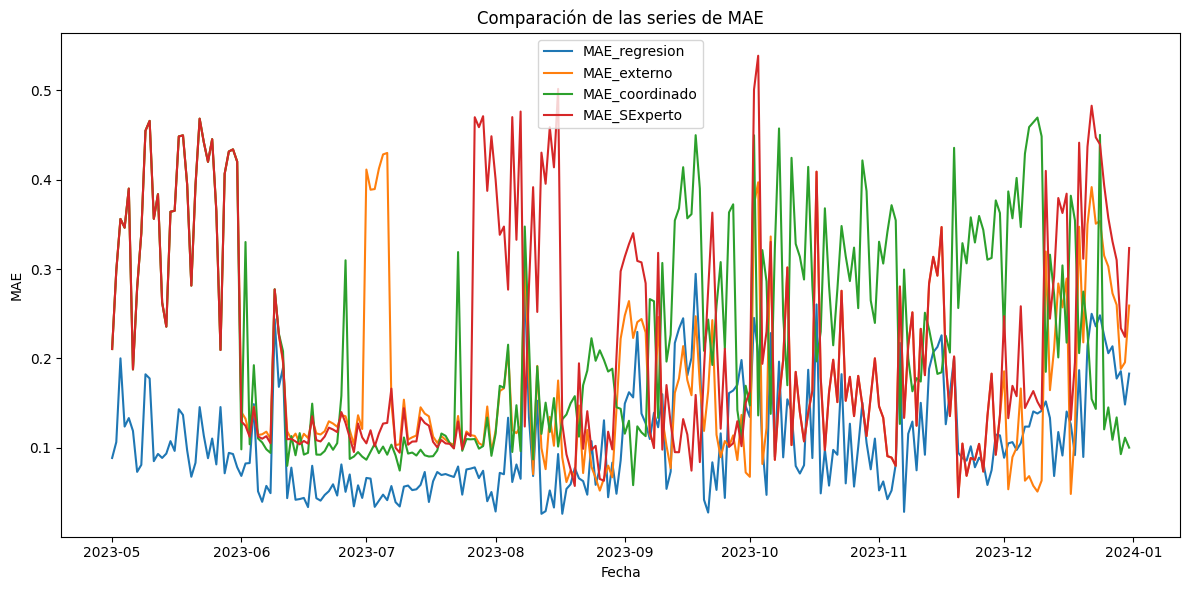

In [221]:


# Graficar las distintas series de MAE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de MAE terminan con 'MAE'
for column in error_diario.columns:
    if column.startswith('MAE'):
        plt.plot(error_diario.index, error_diario[column], label=column)

plt.title('Comparación de las series de MAE')
plt.xlabel('Fecha')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()


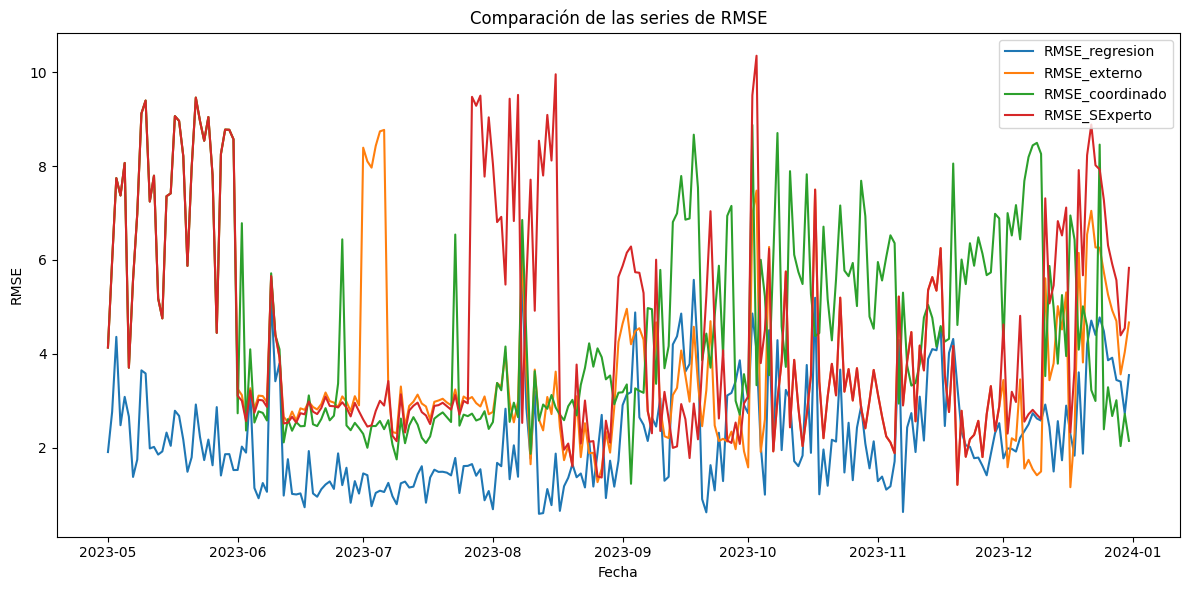

In [219]:
# Graficar las distintas series de RMSE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de RMSE empiezan con 'RMSE'
for column in error_diario.columns:
    if column.startswith('RMSE'):
        plt.plot(error_diario.index, error_diario[column], label=column)

plt.title('Comparación de las series de RMSE')
plt.xlabel('Fecha')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

## Error granularidad semanal

In [239]:
# Agrupar por semana y calcular el MAE semanal para cada tipo de error
error_semanal = pd.DataFrame()

error_semanal['MAE_regresion'] = (error.resample('W', on='Fecha')['MAE_regresion'].mean() / potencia_maxima)
error_semanal['RMSE_regresion'] = (error.resample('W', on='Fecha')['RMSE_regresion'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_semanal['MAE_externo'] = (error.resample('W', on='Fecha')['MAE_externo'].mean() / potencia_maxima)
error_semanal['RMSE_externo'] = (error.resample('W', on='Fecha')['RMSE_externo'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_semanal['MAE_coordinado'] = (error.resample('W', on='Fecha')['MAE_coordinado'].mean() / potencia_maxima)
error_semanal['RMSE_coordinado'] = (error.resample('W', on='Fecha')['RMSE_coordinado'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

# Calcular el MAE y RMSE para el Sistema Experto semanalmente
error['MAE_SExperto'] = np.abs(error['err_SExperto'])
error['RMSE_SExperto'] = error['err_SExperto'] ** 2
error_semanal['MAE_SExperto'] = (error.resample('W', on='Fecha')['MAE_SExperto'].mean() / potencia_maxima)
error_semanal['RMSE_SExperto'] = (error.resample('W', on='Fecha')['RMSE_SExperto'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

# Asegúrate de que 'potencia_maxima' es un escalar si es constante para todo el período o una serie con índices de fecha si varía a lo largo del tiempo.
# Si 'potencia_maxima' varía, deberías hacer un resample de esa serie también y usar el valor semanal correspondiente para cada cálculo.

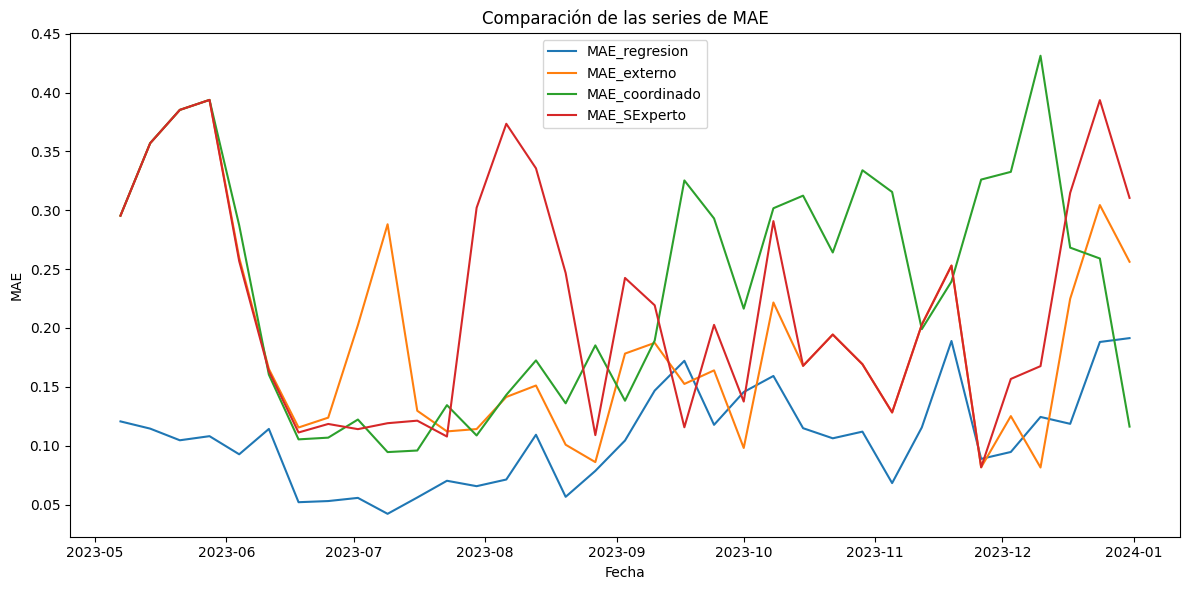

In [240]:

# Graficar las distintas series de MAE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de MAE terminan con 'MAE'
for column in error_semanal.columns:
    if column.startswith('MAE'):
        plt.plot(error_semanal.index, error_semanal[column], label=column)

plt.title('Comparación de las series de MAE')
plt.xlabel('Fecha')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

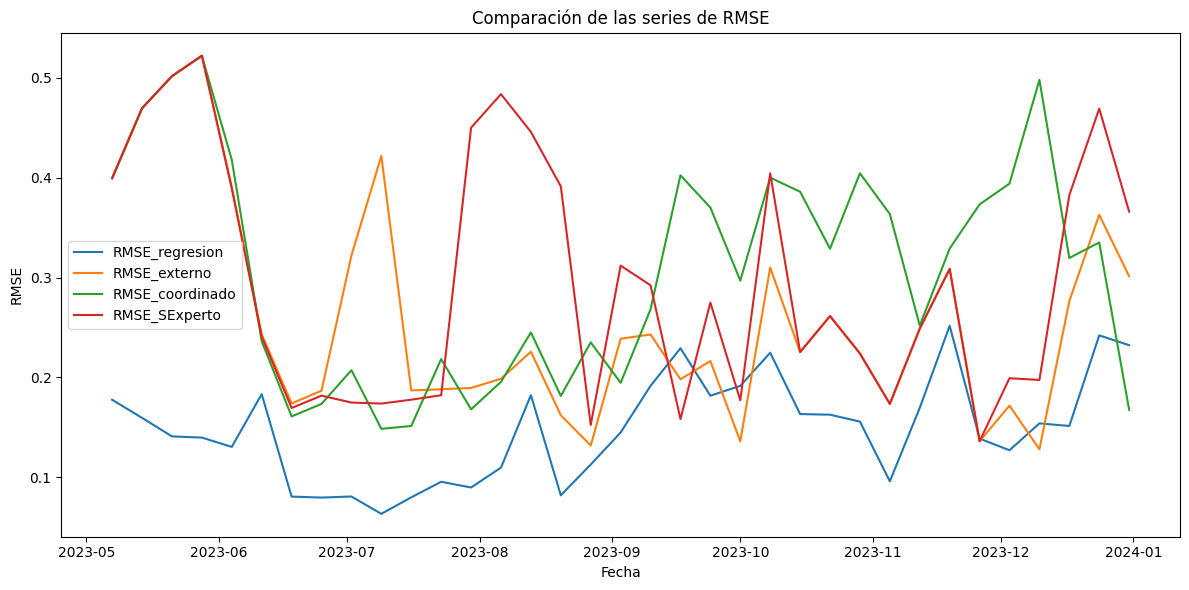

In [241]:
# Graficar las distintas series de RMSE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de RMSE empiezan con 'RMSE'
for column in error_semanal.columns:
    if column.startswith('RMSE'):
        plt.plot(error_semanal.index, error_semanal[column], label=column)

plt.title('Comparación de las series de RMSE')
plt.xlabel('Fecha')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

## Error granularidad mensual

In [242]:
# Agrupar por mes y calcular el MAE mensual para cada tipo de error
error_mensual = pd.DataFrame()

error_mensual['MAE_regresion'] = (error.resample('M', on='Fecha')['MAE_regresion'].mean() / potencia_maxima)
error_mensual['RMSE_regresion'] = (error.resample('M', on='Fecha')['RMSE_regresion'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_mensual['MAE_externo'] = (error.resample('M', on='Fecha')['MAE_externo'].mean() / potencia_maxima)
error_mensual['RMSE_externo'] = (error.resample('M', on='Fecha')['RMSE_externo'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

error_mensual['MAE_coordinado'] = (error.resample('M', on='Fecha')['MAE_coordinado'].mean() / potencia_maxima)
error_mensual['RMSE_coordinado'] = (error.resample('M', on='Fecha')['RMSE_coordinado'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)

# Calcular el MAE y RMSE para el Sistema Experto mensualmente
error['MAE_SExperto'] = np.abs(error['err_SExperto'])
error['RMSE_SExperto'] = error['err_SExperto'] ** 2
error_mensual['MAE_SExperto'] = (error.resample('M', on='Fecha')['MAE_SExperto'].mean() / potencia_maxima)
error_mensual['RMSE_SExperto'] = (error.resample('M', on='Fecha')['RMSE_SExperto'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)


C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\3510918136.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  error_mensual['MAE_regresion'] = (error.resample('M', on='Fecha')['MAE_regresion'].mean() / potencia_maxima)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\3510918136.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  error_mensual['RMSE_regresion'] = (error.resample('M', on='Fecha')['RMSE_regresion'].apply(lambda x: np.sqrt(x.mean())) / potencia_maxima)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\3510918136.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  error_mensual['MAE_externo'] = (error.resample('M', on='Fecha')['MAE_externo'].mean() / potencia_maxima)
C:\Users\prt_isilva\AppData\Local\Temp\ipykernel_8168\3510918136.py:8: FutureWarning: 'M' is deprecated and will be removed in a fu

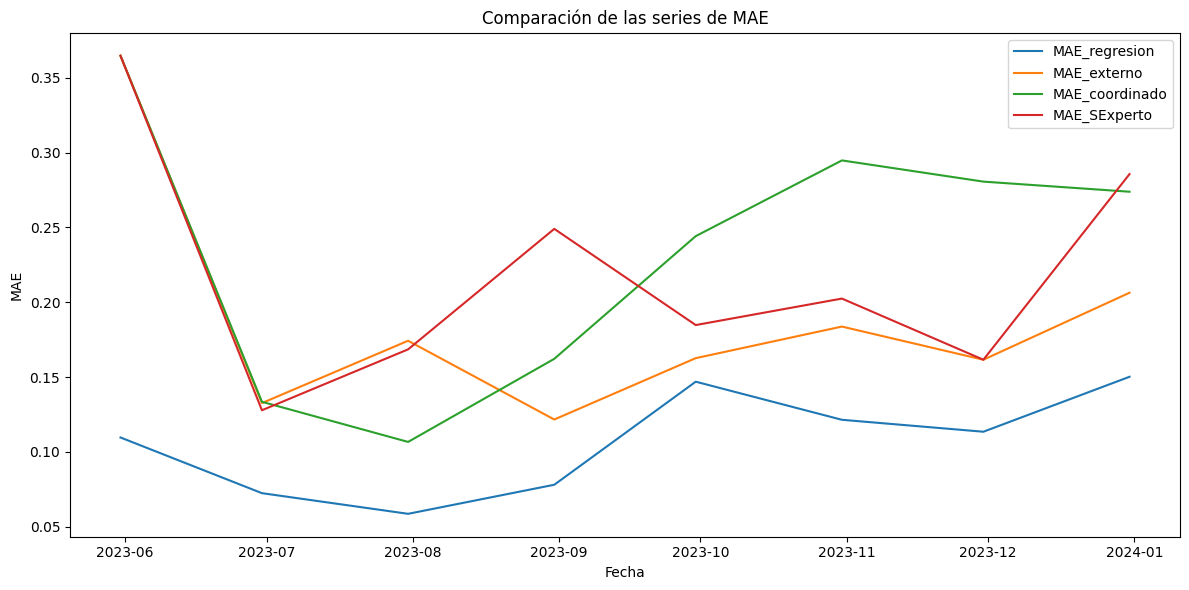

In [243]:
# Graficar las distintas series de MAE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de MAE terminan con 'MAE'
for column in error_mensual.columns:
    if column.startswith('MAE'):
        plt.plot(error_mensual.index, error_mensual[column], label=column)

plt.title('Comparación de las series de MAE')
plt.xlabel('Fecha')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

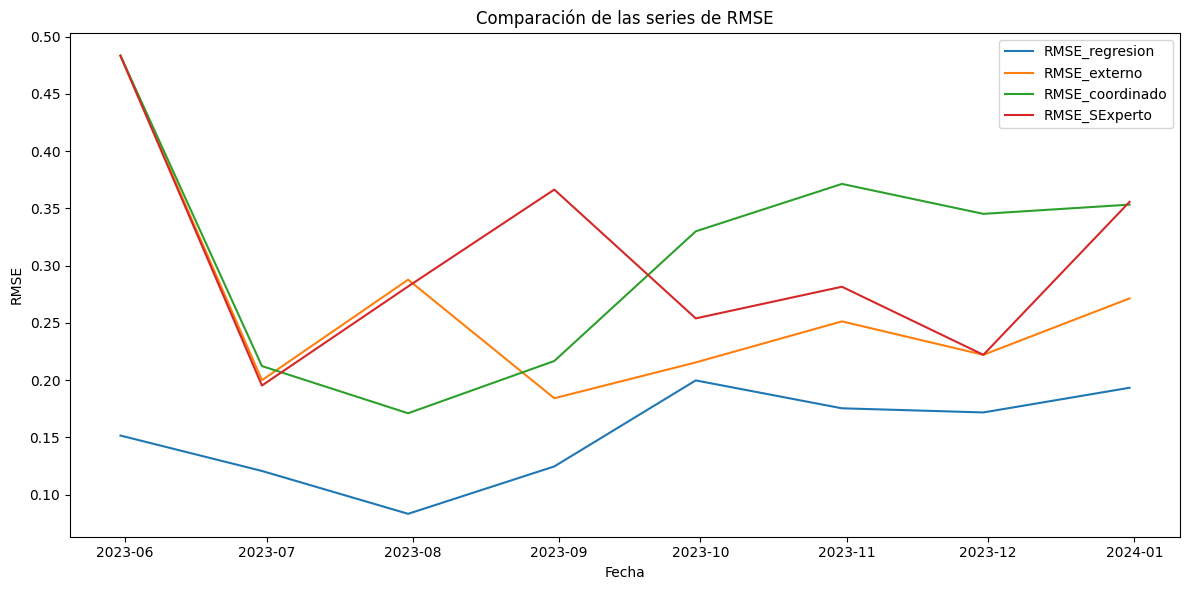

In [244]:
# Graficar las distintas series de RMSE
plt.figure(figsize=(12, 6))
# Asumiendo que las columnas de RMSE empiezan con 'RMSE'
for column in error_mensual.columns:
    if column.startswith('RMSE'):
        plt.plot(error_mensual.index, error_mensual[column], label=column)

plt.title('Comparación de las series de RMSE')
plt.xlabel('Fecha')
plt.ylabel('RMSE')
plt.legend()
plt.tight_layout()
plt.show()

## Error total

In [245]:
# Calcular el MAE y RMSE totales para el período completo para cada tipo de error
error_total = pd.DataFrame(index=['Total'])

error_total['MAE_regresion'] = error['MAE_regresion'].mean() / potencia_maxima
error_total['RMSE_regresion'] = np.sqrt(error['RMSE_regresion'].mean()) / potencia_maxima

error_total['MAE_externo'] = error['MAE_externo'].mean() / potencia_maxima
error_total['RMSE_externo'] = np.sqrt(error['RMSE_externo'].mean()) / potencia_maxima

error_total['MAE_coordinado'] = error['MAE_coordinado'].mean() / potencia_maxima
error_total['RMSE_coordinado'] = np.sqrt(error['RMSE_coordinado'].mean()) / potencia_maxima

# Suponemos que la columna 'err_SExperto' representa el error para el Sistema Experto
error_total['MAE_SExperto'] = np.abs(error['err_SExperto']).mean() / potencia_maxima
error_total['RMSE_SExperto'] = np.sqrt((error['err_SExperto'] ** 2).mean()) / potencia_maxima

# Imprimir los errores totales
print(error_total)

       MAE_regresion  RMSE_regresion  MAE_externo  RMSE_externo  \
Total       0.106353        0.156961     0.188913      0.279745   

       MAE_coordinado  RMSE_coordinado  MAE_SExperto  RMSE_SExperto  
Total         0.23272         0.325427      0.218811       0.318207  


# Otros

In [312]:
datos_central['Día'] = datos_central['Fecha'].dt.date
datos_central


,Fecha,Nombre,Externo,Coordinado,SExperto,Potencia_max_bruta,Generacion_Potencial,Hora,Día
390,2023-01-01 07:00:00,PFV FINIS TERRAE,20.3,36.09,28.198,248.21,0.000000,7,2023-01-01
407,2023-01-01 08:00:00,PFV FINIS TERRAE,83.3,135.79,108.934,248.21,42.204278,8,2023-01-01
472,2023-01-01 09:00:00,PFV FINIS TERRAE,105.4,212.18,137.310,248.21,59.850750,9,2023-01-01
546,2023-01-01 10:00:00,PFV FINIS TERRAE,110.1,244.09,137.310,248.21,57.510000,10,2023-01-01
586,2023-01-01 11:00:00,PFV FINIS TERRAE,114.9,260.37,137.310,248.21,77.441500,11,2023-01-01
...,...,...,...,...,...,...,...,...,...
509420,2023-12-31 16:00:00,PFV FINIS TERRAE,151.7,250.89,126.558,248.21,245.543000,16,2023-12-31
509463,2023-12-31 17:00:00,PFV FINIS TERRAE,152.3,241.25,131.036,248.21,204.208833,17,2023-12-31
509508,2023-12-31 18:00:00,PFV FINIS TERRAE,143.2,196.79,130.640,248.21,155.650000,18,2023-12-31
509630,2023-12-31 19:00:00,PFV FINIS TERRAE,68.3,86.38,64.141,248.21,155.590000,19,2023-12-31


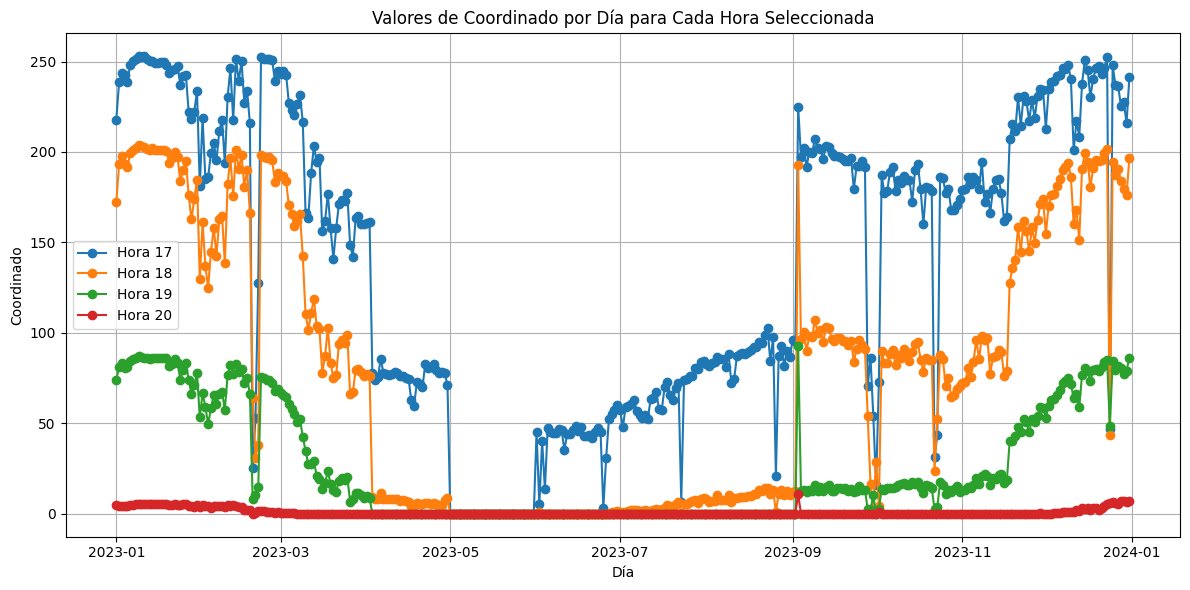

In [313]:
# Filtrar por las horas de interés
# Definir la fecha central y la ventana de tiempo
fecha_central = pd.to_datetime('2023-09-03')
ventana = pd.Timedelta(days=2)
horas_de_interés = [17, 18, 19, 20, 21]
datos_filtrados = datos_central[datos_central['Hora'].isin(horas_de_interés)]

# Pivotear el DataFrame
datos_pivoteados = datos_filtrados.pivot_table(index='Día', columns='Hora', values='Coordinado', aggfunc='mean')

# Graficar una línea por hora con puntos para cada día
plt.figure(figsize=(12, 6))

# Dibujar una línea por cada hora de interés
for hora in horas_de_interés:
    # Verificar si la hora está en las columnas después del pivot
    if hora in datos_pivoteados.columns:
        plt.plot(datos_pivoteados.index, datos_pivoteados[hora], '-o', label=f'Hora {hora}')

plt.title('Valores de Coordinado por Día para Cada Hora Seleccionada')
plt.xlabel('Día')
plt.ylabel('Coordinado')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

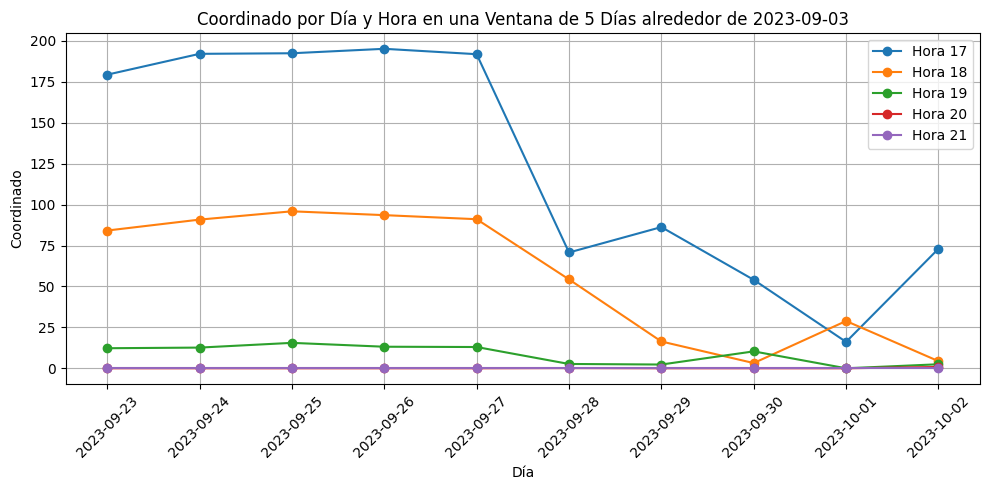

In [64]:
##Este es el cambio de hora

# Definimos la fecha central y el rango de fechas de la ventana
fecha_central = pd.to_datetime('2023-09-28')
ventana = pd.Timedelta(days=5)

# Seleccionamos la ventana de 5 días alrededor de la fecha central (2 días antes y 2 días después)
inicio_ventana = fecha_central - ventana
fin_ventana = fecha_central + ventana

# Filtramos el DataFrame para esta ventana de tiempo
datos_ventana = datos_central[(datos_central['Fecha'] >= inicio_ventana) & (datos_central['Fecha'] <= fin_ventana)]

# Filtramos las horas que nos interesan
horas_interes = [17, 18, 19, 20, 21]
datos_ventana = datos_ventana[datos_ventana['Fecha'].dt.hour.isin(horas_interes)]

# Creamos un gráfico de líneas donde cada línea representa una hora
plt.figure(figsize=(10, 5))

for hora in horas_interes:
    # Filtramos por hora
    df_hora = datos_ventana[datos_ventana['Fecha'].dt.hour == hora]
    # Agrupamos por fecha para asegurarnos de que no haya múltiples entradas por día
    df_hora = df_hora.groupby(df_hora['Fecha'].dt.date)['Coordinado'].mean().reset_index()
    # Graficamos
    plt.plot(df_hora['Fecha'], df_hora['Coordinado'], marker='o', label=f'Hora {hora}')


plt.title('Coordinado por Día y Hora en una Ventana de 5 Días alrededor de 2023-09-03')
plt.xlabel('Día')
plt.ylabel('Coordinado')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotación de las etiquetas del eje X para mejorar la legibilidad
plt.tight_layout()  # Ajustar el layout para evitar que se corten etiquetas o títulos
plt.show()

In [65]:
params = parametros_df.iloc[122:127]
ruta_archivo_excel = 'datos_central.xlsx'

# Usar el método to_excel para exportar el DataFrame a Excel, especificando el engine como 'openpyxl'
datos_central.to_excel(ruta_archivo_excel, engine='openpyxl', index=False)

In [299]:
 params = parametros_df[['h_19','Coordinado-h_19','Externo-h_19']].iloc[122:127]
 params

,h_19,Coordinado-h_19,Externo-h_19
122,0.602269,51.486048,2.998487e-13
123,0.637899,50.751801,-7.904683e-14
124,0.672437,50.047108,-2.845958e-14
125,0.708571,49.302696,3.209832e-13
126,0.712966,49.309997,-1.092017e+03


## ventana movil para 2 de septiembre

In [132]:
Y = datos_central['Generacion_Potencial']
dummies = pd.get_dummies(datos_central['Hora'], drop_first=True, prefix='h')
dummies = dummies.astype(float)
X = pd.concat([datos_central['Externo'],datos_central['Coordinado'], dummies],axis=1)
X = sm.add_constant(X)

horas_relevantes = df_limpio[df_limpio['Nombre']== 'PFV FINIS TERRAE']['Hora'].unique()
horas_relevantes

# Dividir el DataFrame filtrado en entrenamiento y prueba
num_dias_entrenamiento = 120
filas_por_dia = len(horas_relevantes)
# Calcular el número de días en el DataFrame
dias_totales = len(X) // filas_por_dia
print(dias_totales)
# Crear un DataFrame vacío para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()


365


In [133]:
# Agregamos Interacciones a la variabl X
var_ind = ['Externo', 'Coordinado']
for var in var_ind:
    for dummie in dummies.columns:
        nombre_interaccion = f'{var}-{dummie}'
        X[nombre_interaccion] = X[var] * X[dummie]

# Inicializar el DataFrame para almacenar los parámetros estimados
parametros_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las predicciones
predicciones_df = pd.DataFrame()

# Inicializar el DataFrame para almacenar las variables de predicción de cada día
variables_prediccion_df = pd.DataFrame()

# Iterar a través de los días, ajustando el modelo y realizando predicciones

# Definir el conjunto de entrenamiento para la ventana actual
inicio = 125 * filas_por_dia
fin = inicio + num_dias_entrenamiento * filas_por_dia
X_train = X.iloc[inicio:fin]
Y_train = Y.iloc[inicio:fin]

# Ajustar el modelo
modelo = sm.OLS(Y_train, X_train).fit()

# Extraer y almacenar los parámetros estimados para la fecha actual
parametros_actuales = modelo.params
parametros_df = pd.concat([parametros_df, pd.DataFrame(parametros_actuales).T])

# Realizar predicciones para el siguiente día
X_test = X.iloc[fin:fin + filas_por_dia]
predicciones = modelo.predict(X_test)

# Almacenar las predicciones
predicciones_df = pd.concat([predicciones_df, predicciones])

# Almacenar las variables utilizadas para la predicción del nuevo día
variables_prediccion_df = pd.concat([variables_prediccion_df, X_test])

# Restablecer los índices de los DataFrames
parametros_df.reset_index(drop=True, inplace=True)
predicciones_df.reset_index(drop=True, inplace=True)
variables_prediccion_df.reset_index(drop=True, inplace=True)

# Ahora 'parametros_df' contiene los parámetros estimados de cada modelo, 'predicciones_df' las predicciones, 
# y 'variables_prediccion_df' las variables utilizadas para cada predicción.
print(parametros_df)
print(predicciones_df)
print(variables_prediccion_df)

# Eliminación de variables pesadas para optimizar la memoria
#del X, X_train, X_test

          const   Externo  Coordinado           h_5           h_6      h_7  \
0 -1.912498e-12  0.245099    3.840161  9.570465e-13  3.717315e-12 -0.06792   

         h_8         h_9        h_10        h_11  ...  Coordinado-h_12  \
0  20.742766  132.000654  159.162162  171.479648  ...        -3.757942   

   Coordinado-h_13  Coordinado-h_14  Coordinado-h_15  Coordinado-h_16  \
0        -3.793295        -3.779754        -3.745963        -3.714625   

   Coordinado-h_17  Coordinado-h_18  Coordinado-h_19  Coordinado-h_20  \
0        -3.567616        -0.451384        49.302696              0.0   

   Coordinado-h_21  
0              0.0  

[1 rows x 54 columns]
               0
0  -1.912498e-12
1  -9.554518e-13
2   1.804817e-12
3  -6.692596e-02
4   1.751321e+01
5   1.300290e+02
6   1.705432e+02
7   1.800818e+02
8   1.819363e+02
9   1.795554e+02
10  1.770338e+02
11  1.724831e+02
12  1.718731e+02
13  1.705179e+02
14  1.061350e+03
15  4.933371e+03
16  4.224177e+01
17 -3.974144e-13
    const  E